In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from scipy.stats import skew, yeojohnson, zscore
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, average_precision_score
import matplotlib.pyplot as plt
# import tensorflow as tf
import xgboost as xgb
import seaborn as sns

### Isolate Features and Labels in Datasets

In [7]:
train = pd.read_csv("training_data.csv")
train = train.drop(['Id'], axis=1)
test = pd.read_csv("testing_data.csv")
test = test.drop(['Id'], axis=1)
sample_answers = pd.read_csv("sample_answers.csv")
train.describe()

,Y,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,0.941667,1.044733,170294.098133,50.286796,1.045133,-0.996267,1.044200,118973.68680,49.951809,1.044000,...,118279.447467,-0.988267,119807.056800,-0.994467,1.045800,10.327124,117016.246600,182483.565133,1.043067,126201.652333
std,0.234380,0.279173,69514.283902,28.905856,0.248798,1.401041,0.277341,18904.57057,28.767657,0.259105,...,4775.741932,1.415390,6015.017521,1.408416,0.280668,149.278308,10683.932159,100277.315533,0.260032,31716.205071
min,0.000000,1.000000,4673.000000,0.002587,1.000000,-3.000000,1.000000,4674.00000,0.000039,1.000000,...,23779.000000,-3.000000,117880.000000,-3.000000,1.000000,1.770000,4292.000000,3130.000000,1.000000,117879.000000
25%,1.000000,1.000000,117913.000000,25.044640,1.000000,-2.000000,1.000000,118395.00000,25.085547,1.000000,...,118115.000000,-2.000000,118232.000000,-2.000000,1.000000,1.770000,117961.000000,118363.000000,1.000000,118278.000000
50%,1.000000,1.000000,128942.000000,50.514360,1.000000,-1.000000,1.000000,118910.00000,49.951824,1.000000,...,118300.000000,-1.000000,118570.000000,-1.000000,1.000000,1.770000,117961.000000,118960.000000,1.000000,118636.000000
75%,1.000000,1.000000,233714.000000,75.097075,1.000000,0.000000,1.000000,120535.00000,74.706792,1.000000,...,118386.000000,0.000000,119365.000000,0.000000,1.000000,3.540000,117961.000000,290919.000000,1.000000,120006.000000
max,1.000000,11.000000,311867.000000,99.997123,5.000000,1.000000,12.000000,277693.00000,99.996974,7.000000,...,185842.000000,1.000000,266863.000000,1.000000,12.000000,14444.970000,311178.000000,308574.000000,8.000000,310825.000000


## EDA

In [3]:
train['f1'].describe()

count    17768.000000
mean         1.041592
std          0.248852
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: f1, dtype: float64

Y      1.000000
f21    0.030798
f28    0.020773
f22    0.015302
f17    0.011733
f34    0.008405
f19    0.005603
f31    0.005380
f27    0.005279
f4     0.005135
f12    0.004205
f3     0.003510
f18    0.003316
f10    0.002925
f2     0.002849
f13    0.002658
f20    0.001208
f15    0.000447
f24    0.000093
f14   -0.000010
f7    -0.000528
f9    -0.002745
f25   -0.002768
f16   -0.002770
f1    -0.002912
f26   -0.002978
f23   -0.003697
f6    -0.005462
f11   -0.005833
f29   -0.005889
f30   -0.006005
f8    -0.006046
f33   -0.009978
f35   -0.011725
f32   -0.013788
f5    -0.021264
Name: Y, dtype: float64


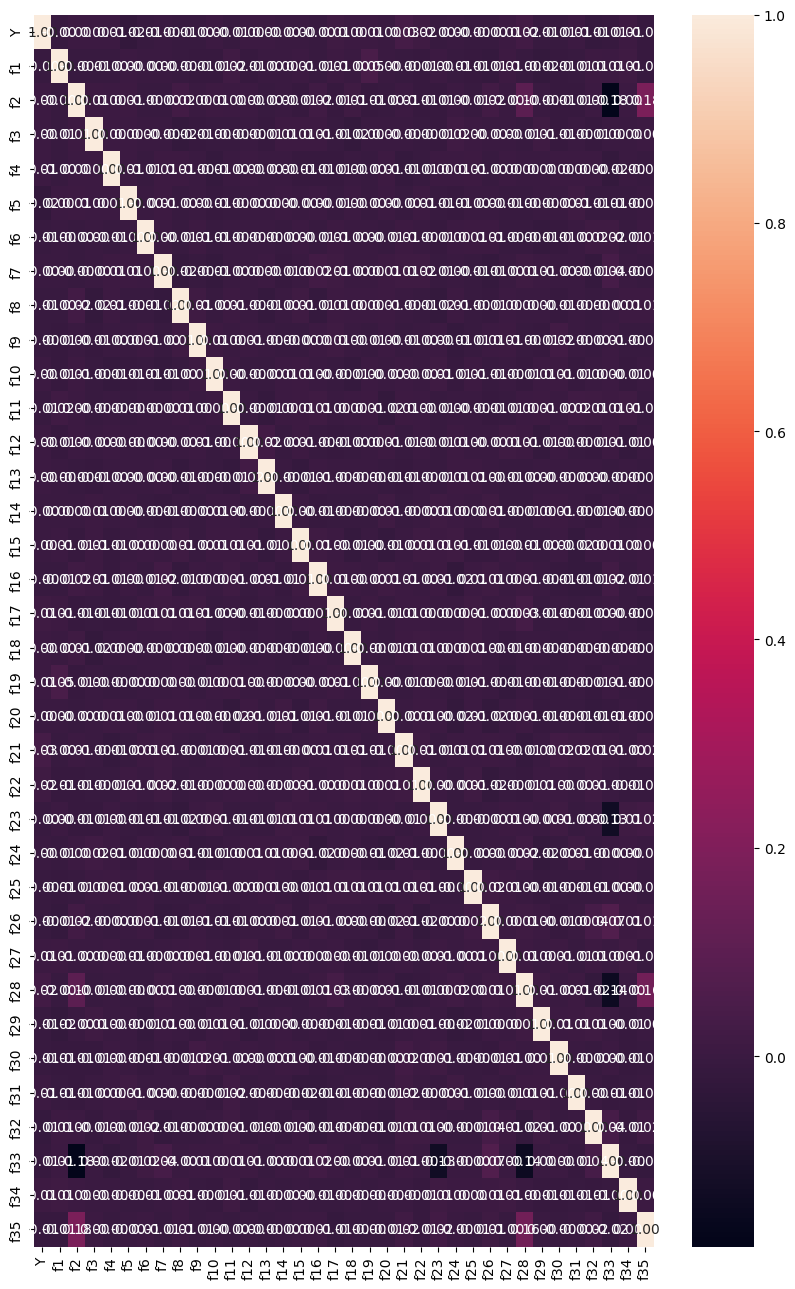

In [8]:
correlation_matrix = train.corr()
print(correlation_matrix["Y"].sort_values(ascending=False))

plt.figure(figsize=(10,16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

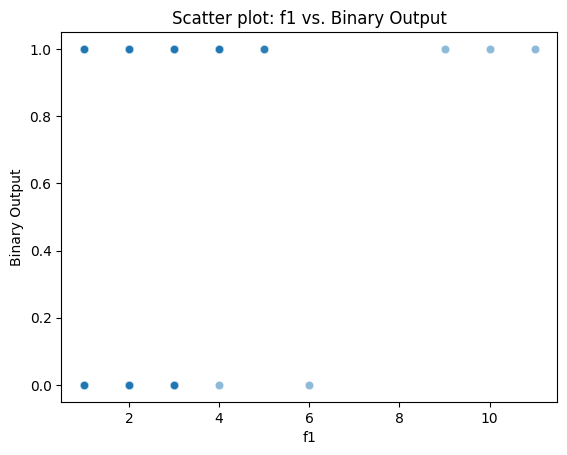

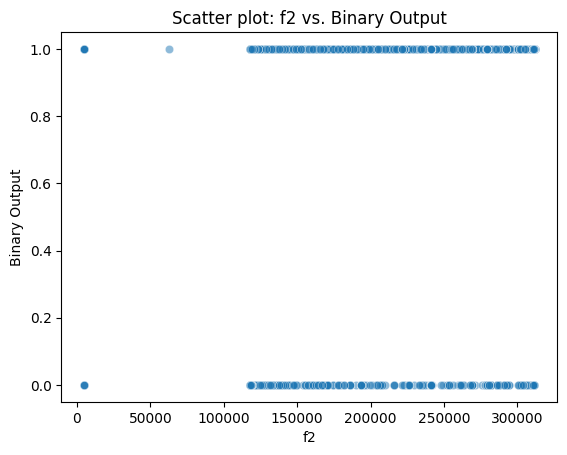

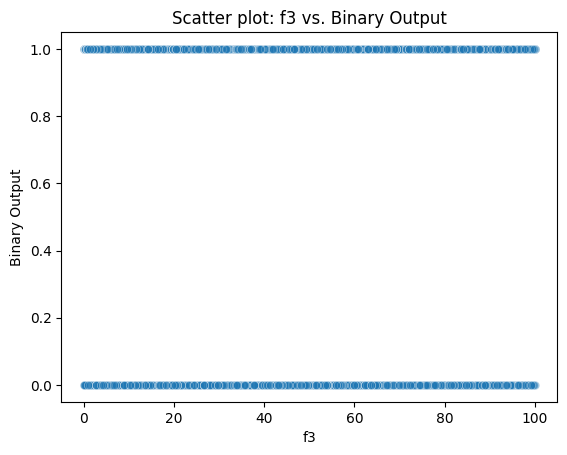

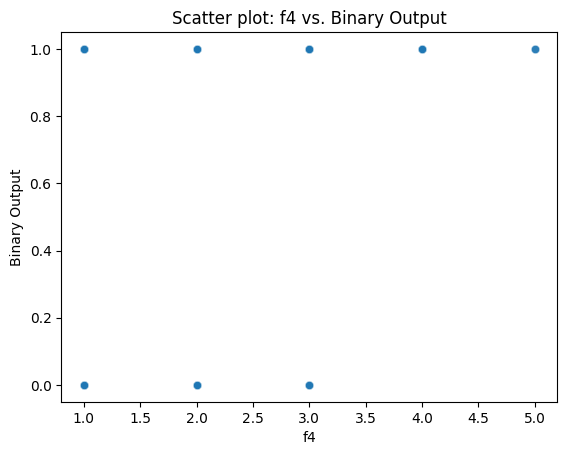

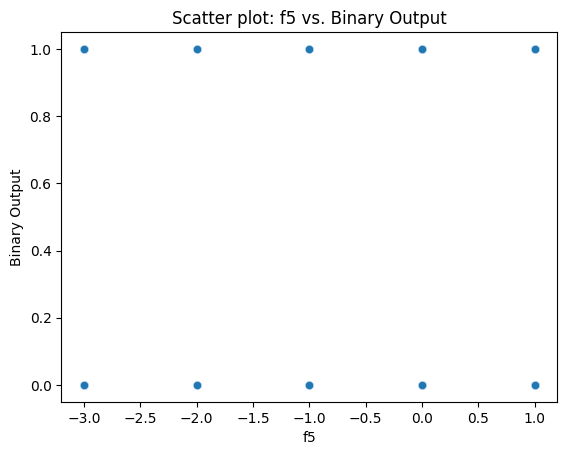

In [10]:
features = train.columns.drop('Y')  # Exclude the target column

# Adjust to the number of features to plot
for feature in features[:5]:
    sns.scatterplot(data=train, x=feature, y='Y', alpha=0.5)
    plt.title(f'Scatter plot: {feature} vs. Binary Output')
    plt.xlabel(feature)
    plt.ylabel('Binary Output')
    plt.show()

### One Hot Encoding

In [10]:
y = train['Y']
continuous_correlation_features = ['f28', 'f32', 'f35']
categorical_correlation_features = ['f21', 'f22', 'f17', 'f34', 'f5', 'f33']
train_continuous = train[continuous_correlation_features]
train_categorical = train[categorical_correlation_features]

train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

## CHECK FOR OUTLIERS AND REMOVE

In [91]:
for data_column in train.columns:
    if data_column == 'Y': continue
    Q1 = train[data_column].quantile(0.25)
    Q3 = train[data_column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_train = train[(train[data_column] < lower_bound) | (train[data_column] > upper_bound)]
    outliers_test = test[(test[data_column] < lower_bound) | (test[data_column] > upper_bound)]

    train = train[(train[data_column] >= lower_bound) & (train[data_column] <= upper_bound)]
    test = test[(test[data_column] >= lower_bound) & (test[data_column] <= upper_bound)]


## TRAIN TEST SPLIT

In [ ]:
X = train.drop('Y', axis=1)
y = train['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train.head()

## CHECK FOR SKEWNESS AND UNSKEW

In [35]:
for data_column in X_train.columns:
    data_skewness = skew(X_train[data_column])

    if data_skewness > 1:
        print(f"Skewness: {data_skewness}")
        print("Data is mad right-skewed.")
    elif data_skewness < -1:
        print(f"Skewness: {data_skewness}")
        print("Data is mad left-skewed.")
    
    if data_skewness > 1 or data_skewness < -1:
        X_train[data_column], _ = yeojohnson(X_train[data_column])

Skewness: 1.3197126103985306
Data is mad right-skewed.
Skewness: 1.0748834441405652
Data is mad right-skewed.
Skewness: 2.260183918210377
Data is mad right-skewed.
Skewness: 1.5218547590549372
Data is mad right-skewed.
Skewness: 1.4956775065359145
Data is mad right-skewed.
Skewness: 2.0789711061178164
Data is mad right-skewed.
Skewness: -1.20234738853105
Data is mad left-skewed.
Skewness: 1.565176309560714
Data is mad right-skewed.


/tmp/ipykernel_34/226084480.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  data_skewness = skew(X_train[data_column])


In [36]:
X_train.describe()

,Id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35
count,1279.000000,1279.0,1279.000000,1279.000000,1279.0,1279.000000,1279.0,1.279000e+03,1279.000000,1279.0,...,1.279000e+03,1279.000000,1279.000000,1279.000000,1279.0,1279.000000,1279.0,1279.000000,1279.0,1279.000000
mean,7544.443315,1.0,8.079061,49.308464,1.0,-0.996091,1.0,4.063628e-01,51.006035,1.0,...,1.164661e+115,-0.979672,118394.686474,-1.010164,1.0,0.190655,117961.0,236606.747459,1.0,118392.338546
std,4329.614181,0.0,0.151555,29.224325,0.0,1.420557,0.0,3.566102e-15,29.034898,0.0,...,2.924789e+113,1.430571,361.576349,1.428764,0.0,0.000391,0.0,83127.793935,0.0,361.650782
min,15.000000,1.0,6.381894,0.024823,1.0,-3.000000,1.0,4.063628e-01,0.209851,1.0,...,1.095117e+115,-3.000000,117908.000000,-3.000000,1.0,0.190415,117961.0,3130.000000,1.0,117905.000000
25%,3924.500000,1.0,7.983314,24.178530,1.0,-2.000000,1.0,4.063628e-01,27.354518,1.0,...,1.152546e+115,-2.000000,118055.000000,-2.000000,1.0,0.190415,117961.0,118638.000000,1.0,118054.000000
50%,7632.000000,1.0,7.986598,48.865563,1.0,-1.000000,1.0,4.063628e-01,51.406097,1.0,...,1.175585e+115,-1.000000,118322.000000,-1.000000,1.0,0.190415,117961.0,290919.000000,1.0,118321.000000
75%,11289.500000,1.0,8.149726,75.028853,1.0,0.000000,1.0,4.063628e-01,75.422684,1.0,...,1.179239e+115,0.000000,118730.000000,0.000000,1.0,0.191277,117961.0,290919.000000,1.0,118728.000000
max,14996.000000,1.0,8.398900,99.961917,1.0,1.000000,1.0,4.063628e-01,99.953020,1.0,...,1.203020e+115,1.000000,119435.000000,1.000000,1.0,0.191335,117961.0,308574.000000,1.0,119433.000000


## Basic Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print("AUC Score: ", roc_auc_score(y_test, y_pred))

## Hyper Parameter Tuning for Random Forest using Cross Validation

Best Parameters for RF: 
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['sqrt']
}
rf_model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


grid_search.fit(X_train, y_train)

rf_model = grid_search.best_estimator_

In [ ]:
y_pred = rf_model.predict(X_train)
print("AUC Score: ", roc_auc_score(y_test, y_pred))
print("Best Parameters: ", grid_search.best_params_)

## Recursive FEATURE ELIMINATION VIA CROSS VALIDATION

In [ ]:
rfecv = RFECV(estimator=rf_model, step=1, cv=StratifiedKFold(5), scoring='accuracy')

rfecv.fit(X_train, y_train)
X_selected = rfecv.transform(X)

In [ ]:
rf_model.fit(X_selected, y_train)

In [ ]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
print("Training AUC: ", roc_auc_score(y_test, y_train_pred))
print("Testing AUC: ", roc_auc_score(y_test, y_test_pred))

## Neural Network Time

In [46]:
nn_model = models.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [47]:
nn_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [ ]:
nn_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)
test_loss, test_acc = nn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

In [ ]:
y_train_pred = nn_model.predict_proba(X_train)[:, 1]
y_test_pred = nn_model.predict_proba(X_test)[:, 1]
print("Training AUC: ", roc_auc_score(y_train, y_train_pred))
print("Testing AUC: ", roc_auc_score(y_test, y_test_pred))

### FEATURE ENGINEERING

In [109]:
# DEFINE GOOD MODEL
xgb_model_tuned = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    tree_method='hist',
    device= 'cuda',
    colsample_bytree=0.7,
    gamma=1.4666666666666666,
    learning_rate=0.1277777777777778,
    max_depth=4,
    min_child_weight=1,
    n_estimators=240,
    reg_alpha=0.061111111111111116,
    reg_lambda=1.2333333333333334,
    subsample=0.9555555555555556
)

xgb_model_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.4666666666666666, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1277777777777778,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=240, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
feature_engineering_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
])

feature_engineering_transformer = ColumnTransformer(
    transformers=[
        ('num', feature_engineering_pipeline, list(range(X_train.shape[1]))),
    ])

In [40]:
pipeline = Pipeline(steps=[('preprocessor', feature_engineering_transformer), ('model', xgb_model_tuned)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsa...
                               feature_types=None, gamma=1.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [42]:
y_train_pred = pipeline.predict_proba(X_train)[:, 1]
y_test_pred = pipeline.predict_proba(X_test)[:, 1]
print("Training AUC: ", roc_auc_score(y_train, y_train_pred))
print("Testing AUC: ", roc_auc_score(y_test, y_test_pred))

Training AUC:  0.9961470200055571
Testing AUC:  0.8513223656390326


## XGBOOST

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    tree_method='hist',
    device= 'cuda'
)

param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 6],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.5, 1, 1.5],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.6, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2, 5],
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid, scoring='roc_auc', cv=5, verbose=2, n_jobs=1)

# grid_search_xgb.fit(X_train, y_train)
# Tune to all of the data:
grid_search_xgb.fit(X, y)

best_xgb = grid_search_xgb.best_estimator_
print(f"Best AUC Score: {grid_search_xgb.best_score_}")

In [ ]:
print(f"Best AUC Score: {grid_search_xgb.best_score_}")
print(f"Best Parameters: {grid_search_xgb.best_params_}")

In [56]:
# best_xgb.fit(X, y)
# test_pred = best_xgb.predict_proba(test)[:, 1]
# solution = pd.DataFrame({"Id": test.Id, "Y":test_pred})
# solution.to_csv("xgb_hypertuned_no_unskew_solutions_entire_train.csv", index = False)

## XGBOOST: fine-tune hyperparameters

In [36]:
base_params = {
    'colsample_bytree': 0.6,
    'gamma': .5,
    'learning_rate': 0.2,
    'max_depth': 6,
    'min_child_weight': 1,
    'n_estimators': 150,
    'reg_alpha': 0.1,
    'reg_lambda': 5,
    'subsample': 1.0
}

param_distributions = {
    'colsample_bytree': np.linspace(base_params['colsample_bytree'] - 0.1, base_params['colsample_bytree'] + 0.1, 10),
    'gamma': np.linspace(max(0, base_params['gamma'] - 0.1), base_params['gamma'] + 0.1, 10),
    'learning_rate': np.linspace(max(0.01, base_params['learning_rate'] - 0.05), base_params['learning_rate'] + 0.05, 10),
    'max_depth': np.arange(max(2, base_params['max_depth'] - 1), base_params['max_depth'] + 2, 1).astype(int),
    'min_child_weight': np.arange(max(1, base_params['min_child_weight'] - 1), base_params['min_child_weight'] + 2, 1).astype(int),
    'n_estimators': np.arange(base_params['n_estimators'] - 50, base_params['n_estimators'] + 100, 10).astype(int),
    'reg_alpha': np.linspace(max(0, base_params['reg_alpha'] - 0.05), base_params['reg_alpha'] + 0.05, 10),
    'reg_lambda': np.linspace(max(0.1, base_params['reg_lambda'] - 0.3), base_params['reg_lambda'] + 0.3, 10),
    'subsample': np.linspace(max(0.5, base_params['subsample'] - 0.1), min(1, base_params['subsample'] + 0.1), 10)
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')

random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_distributions,
    n_iter=500,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [37]:
random_search.fit(X, y)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [ ]:
# CREATE SUBMISSION
test_pred = xgb_model_tuned.predict_proba(test)[:, 1]
solution = pd.DataFrame({"Id": test.Id, "Y":test_pred})
solution.to_csv("xgb_fine_hypertuned_skewed_solutions.csv", index = False)

## XGBOOST: Using unskewed data with hypertuned parameters
Note: the hypertuned parameters below were tuned using skewed data

{'subsample': 0.9555555555555556, 'reg_lambda': 1.2333333333333334, 'reg_alpha': 0.061111111111111116, 'n_estimators': 240, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1277777777777778, 'gamma': 1.4666666666666666, 'colsample_bytree': 0.7}

In [102]:
xgb_model_tuned = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    tree_method='hist',
    device= 'cuda',
    colsample_bytree=0.7,
    gamma=1.4666666666666666,
    learning_rate=0.1277777777777778,
    max_depth=4,
    min_child_weight=1,
    n_estimators=240,
    reg_alpha=0.061111111111111116,
    reg_lambda=1.2333333333333334,
    subsample=0.9555555555555556
)

xgb_model_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.4666666666666666, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1277777777777778,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=240, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [103]:
y_train_pred = xgb_model_tuned.predict_proba(X_train)[:, 1]
y_test_pred = xgb_model_tuned.predict_proba(X_test)[:, 1]
print("Training AUC: ", roc_auc_score(y_train, y_train_pred))
print("Testing AUC: ", roc_auc_score(y_test, y_test_pred))

Training AUC:  0.9919809933778527
Testing AUC:  0.8517972009683603


In [56]:
# CREATE SUBMISSION
test_pred = xgb_model_tuned.predict_proba(test)[:, 1]
solution = pd.DataFrame({"Id": test.Id, "Y":test_pred})
solution.to_csv("xgb_hypertuned_no_unskew_solutions(1).csv", index = False)

### Recursive Feature Elimination: XGB (tuned hyperparameters)

In [104]:
rfecv = RFECV(estimator=xgb_model_tuned, step=1, cv=StratifiedKFold(20), scoring='roc_auc')

rfecv.fit(X_train, y_train)
X_selected_train_xgb = rfecv.transform(X_train)
X_selected_test_xgb = rfecv.transform(X_test)

xgb_model_tuned.fit(X_selected_train_xgb, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.4666666666666666, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1277777777777778,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=240, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [105]:
print("Selected features: ", X_train.columns[rfecv.support_])

y_train_pred = xgb_model_tuned.predict_proba(X_selected_train_xgb)[:, 1]
y_test_pred = xgb_model_tuned.predict_proba(X_selected_test_xgb)[:, 1]
print("Training AUC: ", roc_auc_score(y_train, y_train_pred))
print("Testing AUC: ", roc_auc_score(y_test, y_test_pred))

Selected features:  Index(['f2', 'f7', 'f16', 'f21', 'f23', 'f26', 'f28', 'f32', 'f33', 'f35'], dtype='object')
Training AUC:  0.9713085569515824
Testing AUC:  0.8826838808951974


In [ ]:
# CREATE SUBMISSION
rfecv.fit(X, y)
X_selected_train_xgb = rfecv.transform(X)

xgb_model_tuned.fit(X_selected_train_xgb, y)

selected_test_xgb = rfecv.transform(test)
test_pred = xgb_model_tuned.predict_proba(selected_test_xgb)[:, 1]
solution = pd.DataFrame({"Id": test.Id, "Y":test_pred})
solution.to_csv("xgb_hypertuned_skewed_feature_eliminated_solutions(1).csv", index = False)

### BAGGING TIME

In [106]:
bagging_classifier = BaggingClassifier(
    estimator=xgb_model_tuned,
    n_estimators=100,
    n_jobs=-1,
    verbose=1
)

bagging_classifier.fit(X_selected_train_xgb, y_train)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:  1.2min remaining:  8.5min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:  1.3min finished


BaggingClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.7, device='cuda',
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='auc', feature_types=None,
                                          gamma=1.4666666666666666,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1277777777777778,
                                          max_bin=None, max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=4,
                                          max_leaves=None, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=240,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...),
                  n_estimators=100, n_jobs=-1, verbose=1)

In [107]:
y_train_pred = bagging_classifier.predict_proba(X_selected_train_xgb)[:, 1]
y_test_pred = bagging_classifier.predict_proba(X_selected_test_xgb)[:, 1]
print("Training AUC: ", roc_auc_score(y_train, y_train_pred))
print("Testing AUC: ", roc_auc_score(y_test, y_test_pred))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.5s remaining:    4.3s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.9s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.1s remaining:    1.4s


Training AUC:  0.988550596996622
Testing AUC:  0.8914109605146034


[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.6s finished


In [108]:
# CREATE SUBMISSION
selected_test_xgb = rfecv.transform(test)
test_pred = bagging_classifier.predict_proba(selected_test_xgb)[:, 1]
solution = pd.DataFrame({"Id": test.Id, "Y":test_pred})
solution.to_csv("xgb_fine_hypertuned_skewed_feature_eliminated_bagged_solutions(1).csv", index = False)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.7s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    1.1s finished


## STACKING

In [41]:
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
rf_model = RandomForestClassifier(bootstrap=False,
                                   max_depth=None,
                                   max_features='sqrt',
                                   min_samples_leaf=1,
                                   min_samples_split=2,
                                   n_estimators=200)
base_models = [
    ('rf', rf_model),
    ('xgb', best_xgb),
]

final_estimator_xgb = best_xgb
stacking_model = StackingClassifier(estimators=base_models, final_estimator=final_estimator_xgb, cv=5, n_jobs=-1)
# stacking_model.fit(X_train, y_train)

[06:21:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       n_estimators=200)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6,
                                              device='cuda',
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=1.5,
                                              gr...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=3, max_leaves=None,
                                                 min_child_weight=1,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=200, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=-1)

In [42]:
y_train_pred = stacking_model.predict_proba(X_train)[:, 1]
y_test_pred = stacking_model.predict_proba(X_test)[:, 1]
print("Training AUC: ", roc_auc_score(y_train, y_train_pred))
print("Testing AUC: ", roc_auc_score(y_test, y_test_pred))

Training AUC:  1.0
Testing AUC:  0.7169892430500561


In [43]:
# test_pred = xgb_model_tuned.predict_proba(test)[:, 1]
# solution = pd.DataFrame({"Id": test.Id, "Y":test_pred})
# solution.to_csv("xgb_hypertuned_stacked_no_unskew_solutions.csv", index = False)

## CATBOOST

In [ ]:
cb_model = cb(
    iterations=1000, 
    learning_rate=0.1, 
    depth=6, 
    loss_function='Logloss',
    task_type='GPU',
    devices='0:1',
    verbose=200
)

cat_features = ['f1', 'f4', 'f5', 'f6', 'f7', 'f9', 'f10', 'f12', 'f13', 'f14', 'f17', 'f18', 'f19', 'f21', 'f22', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35']

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

cb_model.fit(train_pool, eval_set=test_pool)

### Stack XGBoost and CatBoost

In [ ]:
logistic_regression_model = LogisticRegression(max_iter=1000)

stack = StackingClassifier(estimators=[('catboost', cb_model), ('xgb', random_search.best_estimator_)], 
                           final_estimator=logistic_regression_model, 
                           cv=5,
                           stack_method='auto',
                           n_jobs=-1,
                           passthrough=False)

stack.fit(X_train, y_train)